This notebook evaluates the performance of a small CNN classifier and several other imported classifiers on the 1D radial profiles of the training and testing data.

In [ ]:
# !pip install numpy opencv-python pillow albumentations tensorflow kagglehub

In [ ]:
# !pip install keras

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import timm

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
import kagglehub

# Free download
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [04:03<00:00, 43.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [ ]:
# Set to a number to specify size of training data; should be an even number
# None = max training size
# TRAIN_SIZE = 10000
TRAIN_SIZE = None

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU.")

CUDA is not available, using CPU.


In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set fixed seed
set_seed(42)

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! chmod 600 /content/kaggle.json
# ! kaggle datasets list

In [ ]:
# Load the dataset
base_dir = path
df_path = "/content"
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
# train_df = pd.read_csv(os.path.join(df_path, "train_5000.csv"))
# test_df = pd.read_csv(os.path.join(df_path, "test_1000.csv"))

# Display basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Reduce size of train dataset for easier processing
if TRAIN_SIZE is not None and TRAIN_SIZE < train_df.shape[0]:
  train_df = train_df.loc[0:(TRAIN_SIZE - 1)]
  print("Train dataset shape after reduction:", train_df.shape)
train_df.head()
train_df.shape

Train dataset shape: (79950, 3)
Test dataset shape: (5540, 1)


(79950, 3)

In [ ]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [ ]:
# Add base directory to all file_name fields to make it easier to read each image
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir, x))
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir, x))
# test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir + "/test_data_v2", x))
# train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir + "/train_data", x))

In [ ]:
print(train_df['file_name'].iloc[0])

/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg


In [ ]:
print(test_df['id'].iloc[0])

/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg


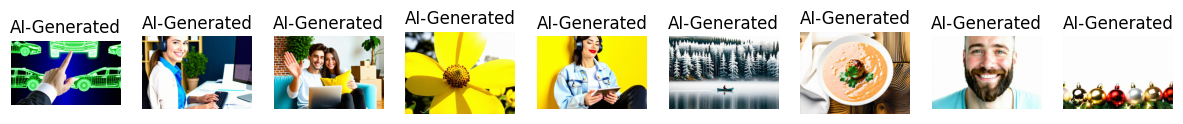

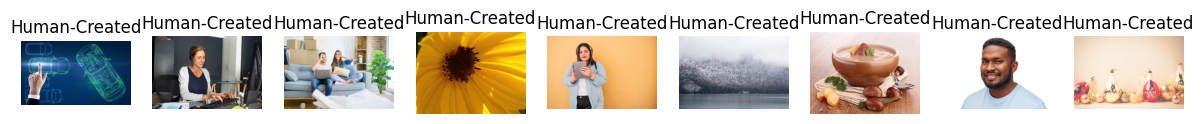

In [ ]:
# Function to display images
def show_images(df, label, num_images=9):
    sample_images = df[df["label"] == label].sample(num_images, random_state=15)["file_name"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()

# Show AI-Generated Images
show_images(train_df, label=1)

# Show Human-Created Images
show_images(train_df, label=0)

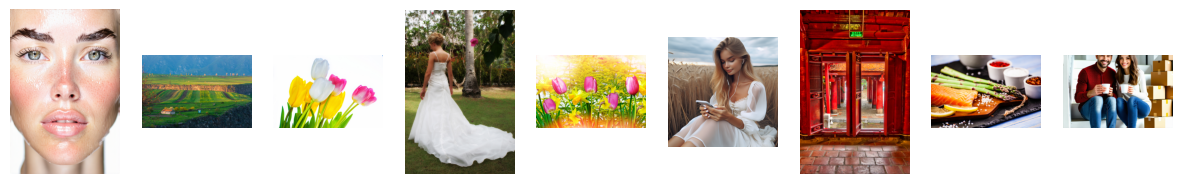

In [ ]:
def show_test_images(df, num_images=9):
    sample_images = df.sample(num_images, random_state=15)["id"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        # plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()

show_test_images(test_df)


First 5 rows of train.csv:
                                           file_name  label
0  /root/.cache/kagglehub/datasets/alessandrasala...      1
1  /root/.cache/kagglehub/datasets/alessandrasala...      0
2  /root/.cache/kagglehub/datasets/alessandrasala...      1
3  /root/.cache/kagglehub/datasets/alessandrasala...      0
4  /root/.cache/kagglehub/datasets/alessandrasala...      1


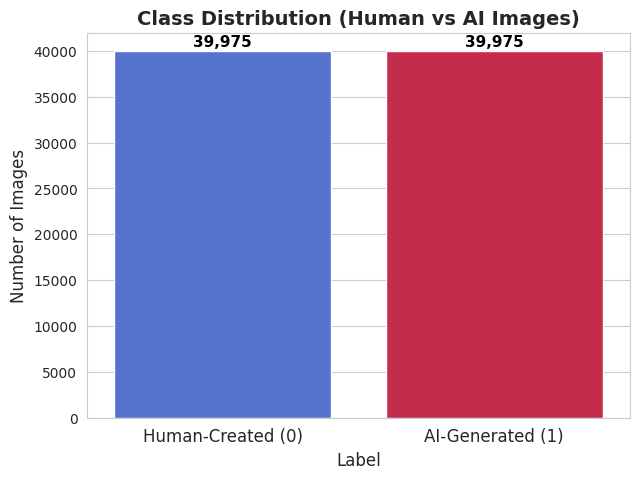

In [ ]:
# Modified from Victor's notebook
df = train_df

# Print the first few rows of train.csv
print("\nFirst 5 rows of train.csv:")
print(df.head())

# Extract only the filename (remove "train_data/" prefix)
# df["file_name"] = df["file_name"].apply(lambda x: os.path.basename(x))

# Construct full image path
# df["full_path"] = df["file_name"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Convert label column to integer
df["label"] = df["label"].astype(int)

# Class Distribution
label_counts = df["label"].value_counts().sort_index()

# Plot Class Distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=["royalblue", "crimson"])
plt.xticks(ticks=[0, 1], labels=["Human-Created (0)", "AI-Generated (1)"], fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.title("Class Distribution (Human vs AI Images)", fontsize=14, fontweight="bold")

# Add text labels on bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=11, fontweight="bold", color="black")

plt.show()

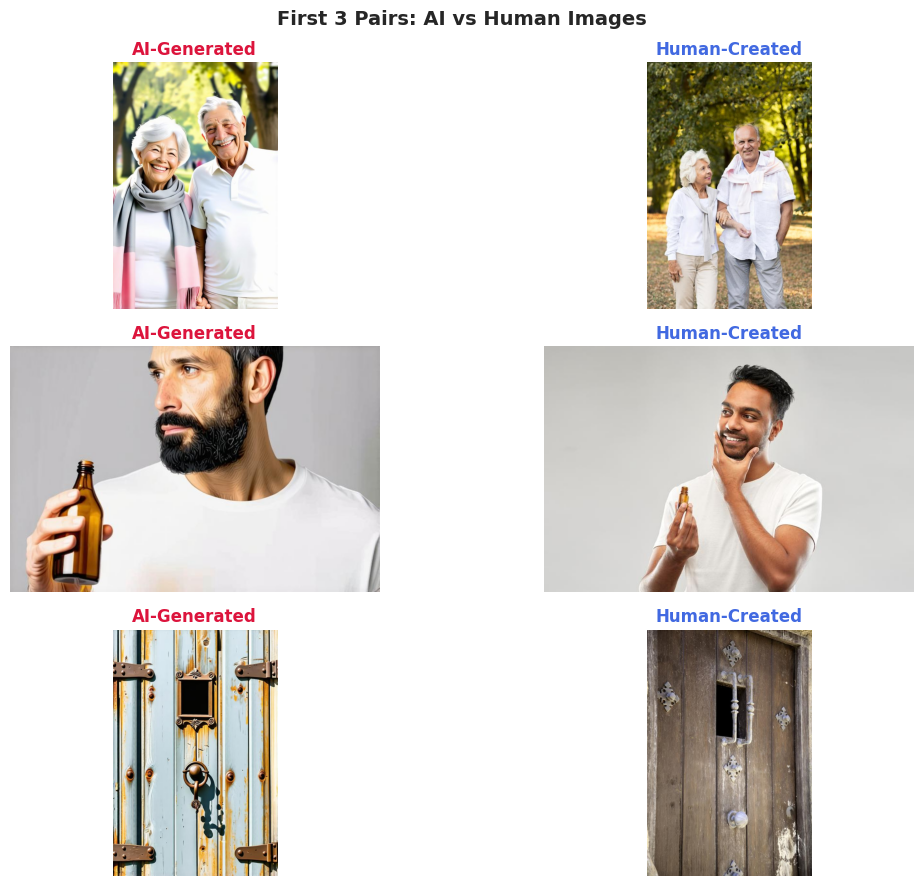

In [ ]:
# Display First 3 Pairs of AI vs Human Images
def show_paired_images():
    """
    Displays the first 3 pairs of images: each AI-generated image placed next to its corresponding human-created image.
    """
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows, 2 columns

    # Select first 3 AI-Human pairs
    ai_images = df[df["label"] == 1].head(3)["file_name"].values  # First 3 AI images (Label 1)
    human_images = df[df["label"] == 0].head(3)["file_name"].values  # First 3 Human images (Label 0)

    for i in range(3):
        ai_img = Image.open(ai_images[i])  # Load AI image
        human_img = Image.open(human_images[i])  # Load Human image

        # AI-generated image (Left)
        axes[i, 0].imshow(ai_img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("AI-Generated", fontsize=12, fontweight="bold", color="crimson")

        # Human-created image (Right)
        axes[i, 1].imshow(human_img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Human-Created", fontsize=12, fontweight="bold", color="royalblue")

    plt.suptitle("First 3 Pairs: AI vs Human Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show the first 3 pairs of images
show_paired_images()

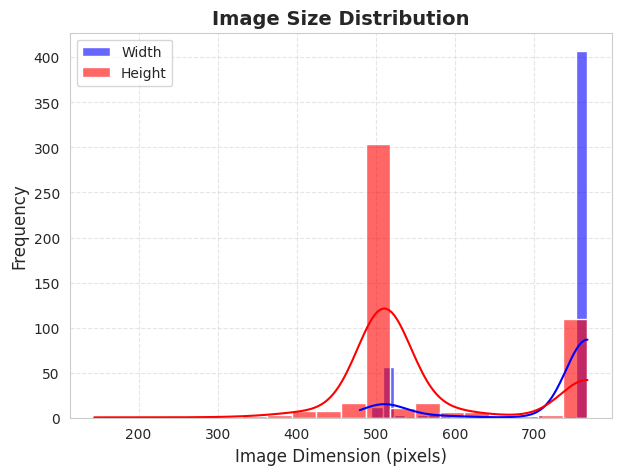

In [ ]:
# Image Size Distribution Plot
image_shapes = []

# Sample 500 images for efficiency
sampled_images = df["file_name"].sample(500, random_state=42)

for img_path in sampled_images:
    try:
        img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB mode
        image_shapes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading image: {img_path} | {e}")

# Convert to DataFrame for visualization
image_sizes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])

# Plot image size distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

sns.histplot(image_sizes_df["Width"], bins=20, color="blue", label="Width", kde=True, alpha=0.6)
sns.histplot(image_sizes_df["Height"], bins=20, color="red", label="Height", kde=True, alpha=0.6)

plt.xlabel("Image Dimension (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Image Size Distribution", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid lines

plt.show()

In [ ]:
print("Minimum width: ", image_sizes_df["Width"].min())
print("Maximum width: ", image_sizes_df["Width"].max())
print("Minimum height: ", image_sizes_df["Height"].min())
print("Maximum height: ", image_sizes_df["Height"].max())

Minimum width:  480
Maximum width:  768
Minimum height:  144
Maximum height:  768


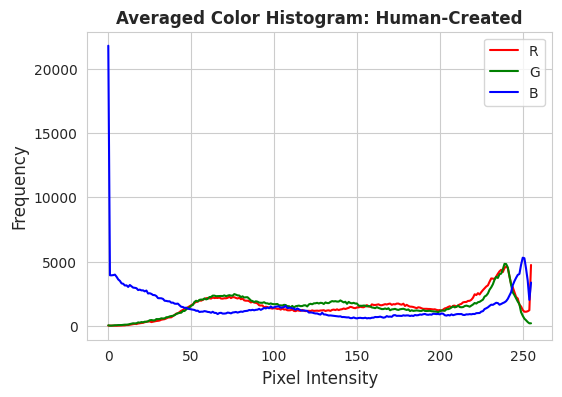

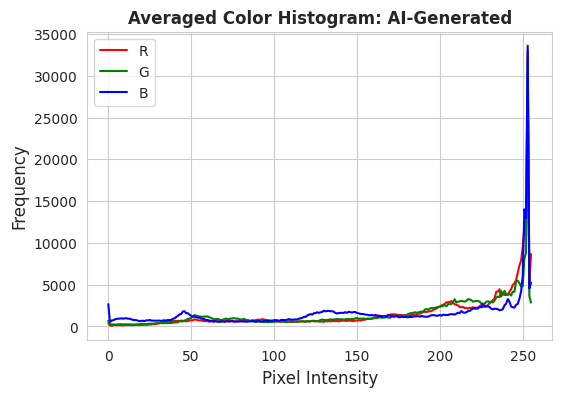

In [ ]:
# Color Histogram Visualization
def plot_color_histogram(image_path, title):
    """
    Plots RGB color histogram for a given image.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("r", "g", "b")
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, label=col.upper())

    plt.title(f"Averaged Color Histogram: {title}", fontsize=12, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.show()

# Show color histogram of the first Human-created image (Label 0)
human_image_path = df[df["label"] == 0]["file_name"].iloc[0]  # Label 0 = Human
plot_color_histogram(human_image_path, "Human-Created")

# Show color histogram of the first AI-generated image (Label 1)
ai_image_path = df[df["label"] == 1]["file_name"].iloc[0]  # Label 1 = AI
plot_color_histogram(ai_image_path, "AI-Generated")

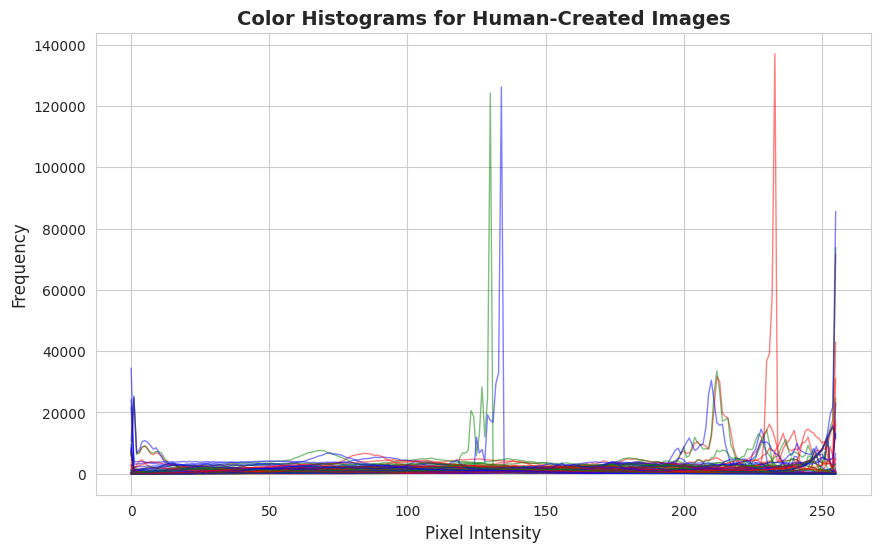

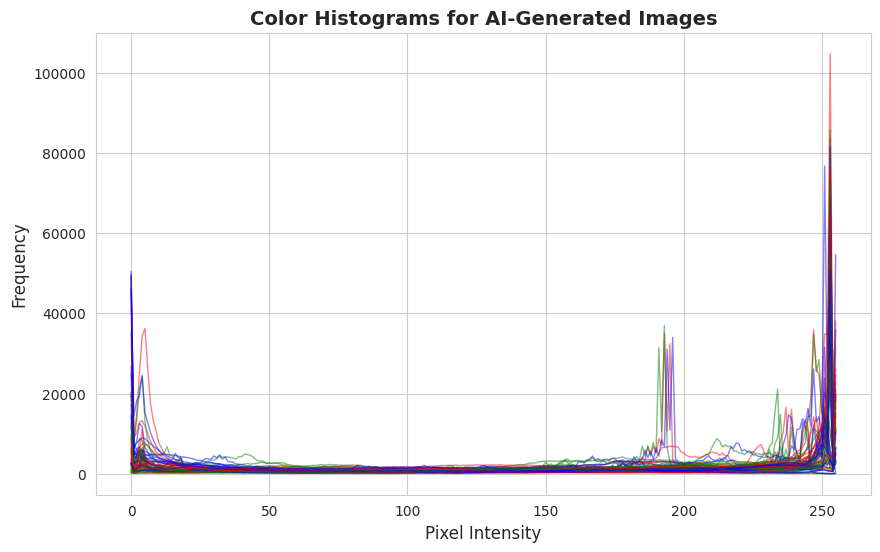

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#  Function to plot color histograms for multiple images (overlay each one)
def plot_overlayed_histograms(image_paths, title, color_labels=("r", "g", "b")):
    """
    Plots RGB color histograms for multiple images, overlaying each image’s histogram.
    """
    plt.figure(figsize=(10, 6))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot histogram for each image (overlayed)
        for i, col in enumerate(color_labels):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, alpha=0.5, linewidth=1)  # Lower alpha for visibility

    plt.title(f"Color Histograms for {title}", fontsize=14, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

# Select 20 AI-generated images and 20 Human-created images
num_samples = 20
human_image_paths = df[df["label"] == 0]["file_name"].iloc[:num_samples].tolist()  # Label 0 = Human
ai_image_paths = df[df["label"] == 1]["file_name"].iloc[:num_samples].tolist()  # Label 1 = AI

# Plot overlayed histograms for Human-created images
plot_overlayed_histograms(human_image_paths, "Human-Created Images")

# Plot overlayed histograms for AI-generated images
plot_overlayed_histograms(ai_image_paths, "AI-Generated Images")

In [ ]:
# Show me the power

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

def center_crop(img, size):
    h, w = img.shape[:2]
    cw, ch = size
    # reflect‑pad if too small
    pad_vert = max(ch - h, 0)
    pad_horz = max(cw - w, 0)
    if pad_vert or pad_horz:
        top = pad_vert // 2
        bottom = pad_vert - top
        left = pad_horz // 2
        right = pad_horz - left
        img = cv2.copyMakeBorder(img, top, bottom, left, right,
                                 cv2.BORDER_REFLECT_101)
        h, w = img.shape[:2]
    # central crop
    cx, cy = w//2, h//2
    x0 = cx - cw//2; x1 = x0 + cw
    y0 = cy - ch//2; y1 = y0 + ch
    return img[y0:y1, x0:x1]

def highpass(img, sigma=3):
    """ img: float32 gray. returns zero‑mean highpass. """
    blur = gaussian_filter(img, sigma=sigma)
    return img - blur

def make_2d_hann(h, w):
    """ separable 2D Hann window """
    wy = np.hanning(h)[:,None]
    wx = np.hanning(w)[None,:]
    return wy * wx

def average_log_spectrum(image_paths, *,
                         crop_size=(224,224),
                         sigma=3,
                         window=True):
    acc = None
    for p in image_paths:
        logmag = compute_logmag(p, crop_size=crop_size, sigma=sigma, window=window)
        acc = logmag if acc is None else acc + logmag

    avg = acc / len(image_paths)
    return avg

def compute_logmag(img_path, *,
                    crop_size=(224,224),
                   sigma=3,
                   window=True):
    # read & preprocess
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = center_crop(img, crop_size)
    hp = highpass(img, sigma=sigma)
    if window:
        win = make_2d_hann(*hp.shape)
        hp = hp * win
    # FFT → log‑mag
    F = np.fft.fftshift(np.fft.fft2(hp))
    logmag = np.log1p(np.abs(F))
    return logmag

def joint_normalize(A, B):
    vmin = min(A.min(), B.min())
    vmax = max(A.max(), B.max())
    A2 = (A - vmin) / (vmax - vmin)
    B2 = (B - vmin) / (vmax - vmin)
    return A2, B2

def radial_profile(img, nbins=100):
    """Compute radial average of `img` around its center."""
    h, w = img.shape
    cy, cx = (h//2, w//2)
    Y, X = np.ogrid[:h, :w]
    R = np.hypot(X-cx, Y-cy)
    # bin by integer radius
    r_i = R.astype(np.int32)
    max_r = min(cx, cy, nbins)
    rad_mean = np.bincount(r_i.ravel(), img.ravel(), minlength=max_r+1)
    rad_count = np.bincount(r_i.ravel(), minlength=max_r+1)
    radial_prof = rad_mean[:max_r] / (rad_count[:max_r] + 1e-8)
    return radial_prof

def plot_2d(A, title):
    plt.figure(figsize=(6,6))
    plt.imshow(A, cmap='viridis', origin='lower')
    plt.title(title)
    plt.axis('off')

def plot_radial(r0, r1):
    freqs = np.arange(len(r0))
    plt.figure(figsize=(6,4))
    plt.plot(freqs, r0, label='real (0)')
    plt.plot(freqs, r1, label='AI (1)')
    plt.xlabel('Spatial frequency (px)')
    plt.ylabel('Avg log‑power')
    plt.legend()



Either load the logmag features from a file or compute them manually (takes about 22 minutes)

In [ ]:
# skipping since it's not needed for the radial profile CNN

# specs_train = np.load("train_specs.npy", mmap_mode="r")    # shape [N, H, W]
# specs_test = np.load("test_specs.npy", mmap_mode="r")  # shape [N, H, W]
# print(specs_train.shape, specs_test.shape)

In [ ]:
# np.save("train_specs.npy", specs_train.astype(np.float32))
# np.save("test_specs.npy", specs_test.astype(np.float32))

In [ ]:


# train_paths = train_df['file_name'].tolist()
# test_paths = test_df['id'].tolist()

# N = len(train_paths)
# H, W = 224, 224
# specs_train = np.zeros((N, H, W), dtype=np.float32)

# N = len(test_paths)
# specs_test = np.zeros((N, H, W), dtype=np.float32)

# # — loop and fill —
# for i, p in enumerate(tqdm(train_paths, desc="Precomputing training spectra")):
#     specs_train[i] = compute_logmag(p, crop_size=(H,W), sigma=3, window=True)

# for i, p in enumerate(tqdm(test_paths, desc="Precomputing testing spectra")):
#     specs_test[i] = compute_logmag(p, crop_size=(H,W), sigma=3, window=True)

# # — save to disk —
# np.save("train_specs.npy", specs_train.astype(np.float16))
# np.save("test_specs.npy", specs_test.astype(np.float32))

In [ ]:
# print(specs_train.shape, specs_test.shape)

In [ ]:
# This method is supposed to get the mean and std for the logmag image data in a way that prevents overloading the RAM.
# The values had already been computed, so they don't need to be recomputed.
def streaming_mean_std(mm_array, chunk_size=500):
    count = 0
    mean = 0.0
    M2 = 0.0

    N = mm_array.shape[0]
    for i in range(0, N, chunk_size):
        chunk = mm_array[i:i+chunk_size].astype(np.float32)
        # mask out any infinities
        chunk = chunk[np.isfinite(chunk)]
        if chunk.size == 0:
            continue
        # flatten to 1D
        flat = chunk.ravel()
        n = flat.size
        mean_chunk = flat.mean()
        var_chunk  = flat.var()

        # Welford update
        delta = mean_chunk - mean
        total = count + n
        mean = (mean * count + mean_chunk * n) / total
        M2 += var_chunk * n + delta * delta * (count * n) / total
        count = total

    std = np.sqrt(M2 / count)
    return mean, std

# spec_train_mean, spec_train_std = streaming_mean_std(specs_train)
spec_train_mean, spec_train_std = 5.9098186, 1.4327419

In [ ]:
print(spec_train_mean, spec_train_std)
# 5.9098186 1.4327419

5.9098186 1.4327419


In [ ]:
# --- USAGE ----------------------------------------------------------

paths1 = train_df[train_df["label"]==1].sample(2000, random_state=42)['file_name']
paths0 = train_df[train_df["label"]==0].sample(2000, random_state=42)['file_name']
# logmags1 = specs_train[train_df["label"]==1].sample(2000, random_state=42)
# logmags0 = specs_train[train_df["label"]==0].sample(2000, random_state=42)

# compute class‑averages
A1 = average_log_spectrum(paths1, crop_size=(224,224), sigma=3, window=True)
A0 = average_log_spectrum(paths0, crop_size=(224,224), sigma=3, window=True)

# # normalize them together for fair color‑scaling
D1, D0 = joint_normalize(A1, A0)

r0, r1 = radial_profile(A0, nbins=112), radial_profile(A1, nbins=112)

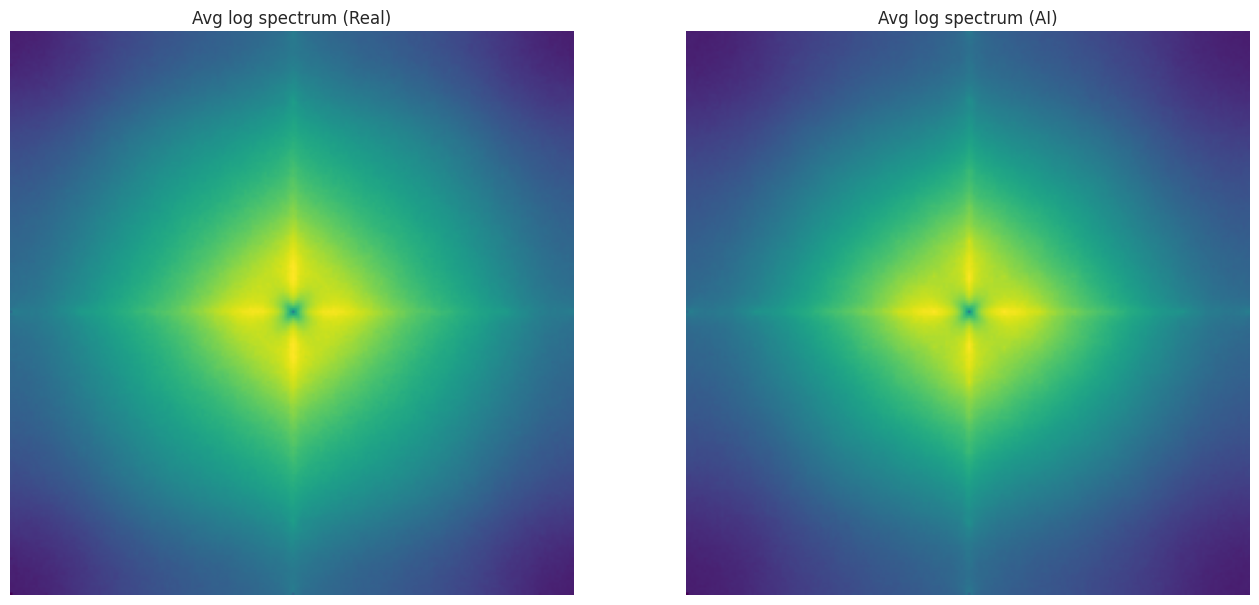

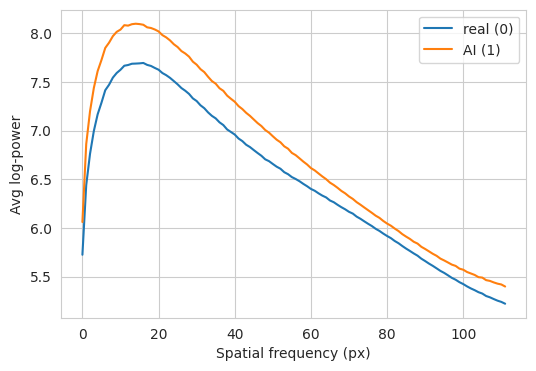

In [ ]:
# show the 2D spectra

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(D0, cmap="viridis", origin="lower")
axes[0].set_title("Avg log spectrum (Real)")
axes[0].axis('off')

axes[1].imshow(D1, cmap="viridis", origin="lower")
axes[1].set_title("Avg log spectrum (AI)")
axes[1].axis('off')

plt.show()

# compute & plot radial 1D profiles

plot_radial(r0, r1)

plt.show()

In [ ]:
# prompt: initialize arrays spect_features, edge_features, and hog_features by reading data from spect_features.json, edge_features.json, hog_features.json

# This is to make it easier to rerun the notebook, since you don't have to run the get_spectral_features
# process on every single sample every time you want to run the notebook.
import json
import numpy as np
spect_features, spect_test_features = [], []

# Load features from JSON files
with open('spect_features.json', 'r') as f:
    spect_features = np.array(json.load(f))

with open('spect_test_features.json', 'r') as f:
    spect_test_features = np.array(json.load(f))

print(f"Spect Features Shape: {spect_features.shape}")  # (num_samples, 112)

Spect Features Shape: (79950, 112)


In [ ]:
# Get spectral features for each sample in the training and testing set

train_X, train_y = train_df['file_name'], train_df['label']
print(train_X.shape, train_y.shape)

def load_and_preprocess(img_path, crop_size=(224, 224)):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
  img = center_crop(img, crop_size)
  return img

def get_spectral_features(paths, window=True):
  spect_features = []
  # logmags = []
  for img_path in paths:
    logmag = compute_logmag(img_path, crop_size=(224,224), sigma=3, window=window)
    # logmags.append(logmag)
    r    = radial_profile(logmag, nbins=112)
    spect_features.append(r)        # length‑112 vector
  return np.array(spect_features)


In [ ]:
if len(spect_features) == 0:
  spect_features = get_spectral_features(train_X)
if len(spect_features) == 0:
  spect_test_features = get_spectral_features(test_df['id'])
spect_features.shape

(79950, 112)

In [ ]:
spect_features.shape

(79950, 112)

In [ ]:
# prompt: export spect_features to .json file

import json

# Export spect_features to a JSON file
with open('spect_features.json', 'w') as f:
    json.dump(spect_features.tolist(), f)

with open('spect_test_features.json', 'w') as f:
    json.dump(spect_test_features.tolist(), f)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize features for better t-SNE performance
spect_sample = spect_features[:2000]
print(spect_sample.shape)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(spect_sample)
features_reduced = PCA(n_components=50).fit_transform(features_scaled)
features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features_reduced)


(2000, 112)


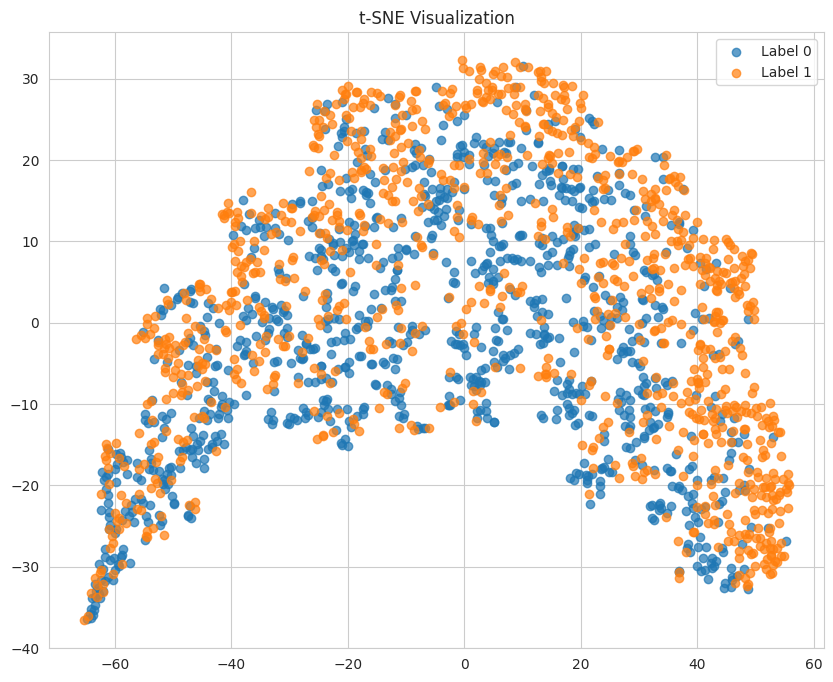

In [ ]:
# Plot the t-SNE result with color-coding for class labels
train_X, train_y = train_df['file_name'], train_df['label']
plt.figure(figsize=(10, 8))
# Scatter plot for each class
label_samples = train_y[:2000]
for class_value in np.unique(label_samples):
    idx = label_samples == class_value
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1],
                label=f'Label {class_value}', alpha=0.7)

plt.title('t-SNE Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


X_train, X_val, y_train, y_val = train_test_split(spect_features, train_y, test_size=0.2, random_state=42)

X_t = torch.from_numpy(X_train).float()
y_t = torch.from_numpy(y_train.values).long()
val_t = torch.from_numpy(X_val).float()
val_l = torch.from_numpy(y_val.values).long()

train_ds = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = TensorDataset(val_t, val_l)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(63960, 112) (63960,)
(15990, 112) (15990,)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import timm

Set up the CNN

In [ ]:
import torch.nn as nn

class SpecMLP(nn.Module):
    def __init__(self,
                 input_dim=112,
                 hidden_dims=(256,128),
                 dropout=0.2,
                 use_batchnorm=True):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


Set up a dataset to apply transformations to the radial profiles

In [ ]:
class RadialDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
    def __getitem__(self, idx):
      r = self.radial_profiles[idx]              # torch.Tensor [112]
      if self.spec_transforms:
          r = self.spec_transforms(r)
      return r, int(self.labels[idx])

In [ ]:
import torch
import torch.nn.functional as F

def mixup_collate(batch, alpha=0.4, num_classes=2):
    xs = torch.stack([item[0] for item in batch], dim=0)            # [B, L]
    ys = torch.tensor([item[1] for item in batch], dtype=torch.long) # [B]
    # one-hot
    Ys = F.one_hot(ys, num_classes).float()                         # [B, num_classes]

    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(len(xs))
    x2, y2 = xs[idx], Ys[idx]

    x_mix = lam * xs + (1 - lam) * x2
    y_mix = lam * Ys + (1 - lam) * y2

    return x_mix, y_mix

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_f1s, fold):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(18, 5))


    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss - Fold {fold}")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, [acc.cpu().numpy() for acc in train_accuracies], label='Train Acc')
    plt.plot(epochs_range, val_accuracies, label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - Fold {fold}")
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_f1s, label='Val F1')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title(f"Validation F1 Score - Fold {fold}")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Let's go even further beyond and derive features from the portion of spect_features
# where the difference between AI and real image is highest

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

radial_np = np.array(spect_features)

# compute band stats
def band_stats(r, lo=10, hi=30):
    band = r[lo:hi]
    return {
        'band_mean':     band.mean(),
        'band_std':      band.std(),
        'band_max':      band.max(),
        'band_centroid': (np.arange(lo,hi)*band).sum() / (band.sum()+1e-8)
    }

# list of dicts → DataFrame of shape (N,4)
df_band = pd.DataFrame(band_stats(r) for r in radial_np)

def spectral_entropy(r):
    p = r.clip(min=0)
    p = p / (p.sum()+1e-8)
    return - (p * np.log(p + 1e-12)).sum()

df_band['entropy'] = [spectral_entropy(r) for r in radial_np]

def compute_spectral_rolloff(radial_profile, roll_percent=0.85):
    total_energy = np.sum(radial_profile)
    cumulative_energy = 0
    roll_off_frequency = 0

    for i, energy in enumerate(radial_profile):
        cumulative_energy += energy
        if cumulative_energy >= total_energy * roll_percent:
            roll_off_frequency = i
            break

    return roll_off_frequency

df_band['roll_off'] = [compute_spectral_rolloff(r) for r in radial_np]



# concatenate into one big feature matrix
X_np = np.hstack([ radial_np, df_band.values ])

In [ ]:
X_np.shape

(79950, 118)

In [ ]:
radial_np_test = np.array(spect_test_features)
df_band_test = pd.DataFrame(band_stats(r) for r in radial_np_test)
df_band_test['entropy'] = [spectral_entropy(r) for r in radial_np_test]
df_band_test['roll_off'] = [compute_spectral_rolloff(r) for r in radial_np_test]
X_np_test = np.hstack([ radial_np_test, df_band_test.values ])
X_np_test.shape

(5540, 118)

In [ ]:
import torch
import torch.nn.functional as F
import random

class SpectralJitter:
    """Add Gaussian noise to each bin"""
    def __init__(self, sigma=0.02):
        self.sigma = sigma

    def __call__(self, x):
        # x: Tensor [C, L] or [L]
        return x + torch.randn_like(x) * self.sigma


class SpectralDropout:
    """Zero out a random fraction of bins"""
    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, x):
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask


class FrequencyWarp:
    """Randomly stretch/compress the 1D axis and re‑interpolate back to length L"""
    def __init__(self, scale_range=(0.9, 1.1)):
        self.scale_range = scale_range

    def __call__(self, x):
        L = x.shape[-1]
        scale = random.uniform(*self.scale_range)
        # build a source grid [0,1] → target grid
        orig_pts = torch.linspace(0, 1, L, device=x.device)
        warped_pts = (orig_pts - 0.5) * scale + 0.5
        # clamp into [0,1]
        warped_pts = warped_pts.clamp(0, 1)
        # map back to indices [0, L-1]
        idx = warped_pts * (L - 1)
        # use 1‑D linear sampling
        x = x.unsqueeze(0).unsqueeze(0)  # [1,1,L]
        warped = F.grid_sample(
            x,
            idx.view(1,1,-1,1) * 2 - 1,    # grid_sample expects coords in [-1,+1]
            mode='bilinear',
            padding_mode='zeros',
            align_corners=True
        )
        return warped.view(-1)


from torchvision import transforms
spec_transforms = transforms.Compose([
    SpectralJitter(sigma=0.03),
    SpectralDropout(p=0.1),
    FrequencyWarp(scale_range=(0.95,1.05)),
])

In [ ]:
def get_scheduler(optimizer, name):
    if name == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5)
    elif name == 'step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif name == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    else:
        return None


In [ ]:
epochs = 10
# epochs_without_improvement = 0
patience = 2
overall_best_f1 = 0.0
results = {}
overall_best_config = ""
pos_weight = 0.5
def train_fold(train_idx, val_idx, fold, config):
    global overall_best_f1, overall_best_config  # Declare as global
    # config is a dict containing all hyperparams
    model = SpecMLP(
        input_dim   = config['input_dim'],
        hidden_dims = config['hidden_dims'],
        dropout     = config['dropout'],
        # use_batchnorm = config['use_batchnorm']
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['lr'],
        weight_decay=0.0
    )
    scheduler = get_scheduler(optimizer, config['scheduler'])
    # pw = torch.tensor([pos_weight]).to(device)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.KLDivLoss(reduction='batchmean')


    epochs   = 10
    patience = 2
    batch_size = 64

    # split tensors
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]

    X_train = X_train.cpu().numpy()
    X_val = X_val.cpu().numpy()

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert back to PyTorch tensors after scaling
    X_train = torch.from_numpy(X_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_train = y_train
    y_val = y_val


    # dataloaders
    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    train_loader = DataLoader(
        train_ds,
        batch_size=64,
        shuffle=True,
        collate_fn=lambda b: mixup_collate(b, alpha=0.3),
        num_workers=4,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=64,
        shuffle=False,
        collate_fn=lambda b: mixup_collate(b, alpha=0.3),
        num_workers=4,
    )

    # Initialize lists to store loss, accuracy, and F1 scores
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1s = []


    val_loss = 0.0
    val_acc = 0.0

    best_f1 = 0.0
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Train the model
    for epoch in range(epochs):

        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_f1 = 0.0

        # training
        model.train()
        for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            logits = model(data)
            log_probs = F.log_softmax(logits, dim=1)  # [B,2]
            loss = criterion(F.log_softmax(logits, dim=1), label)
            # label = label.unsqueeze(1).float()  # Add a dimension and convert to float

            # loss = criterion(logits[:,1], label.squeeze(1))
            # loss = criterion(logits, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_accuracy += (logits.argmax(dim=1) == label.argmax(dim=1)).float().mean()

        epoch_loss /= len(train_loader)
        epoch_accuracy /= len(train_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # validation
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                # data, label = data.to(device), label.to(device)
                data = data.to(device, non_blocking=True)
                label = label.to(device, non_blocking=True)
                logits = model(data)
                # loss = criterion(logits[:,1], label.float())
                loss = criterion(F.log_softmax(logits, dim=1), label)
                # loss = criterion(logits, label)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                target_labels = label.argmax(dim=1)
                val_acc += (preds == target_labels).float().mean().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(target_labels.cpu().numpy())


        f1 = f1_score(all_labels, all_preds)
        print(f"Fold {fold}, Epoch {epoch}, Val F1 = {f1:.4f}")


        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Calculate F1 Score
        val_f1 = f1_score(all_labels, all_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)


        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )

        config_key = f"spect_mlp_fold{fold}_lr{config['lr']}_dim{config['hidden_dims']}"
        # Early Stopping Logic
        # Check improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"best_weights_{config_key}.pth")
            torch.save(model, f"best_model_{config_key}.pt")
            print(f"Model saved with best F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement at epoch {epoch+1}")

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        if epochs_without_improvement >= patience:
            print(f"Stopped early at epoch {epoch+1}")
            break
        model.eval()

    results[config_key] = {
        "best_f1": best_f1,
        "fold": fold,
        "model": "spect_mlp"
    }

    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key


    with open("model_f1_results.json", "w") as f:
        json.dump(results, f, indent=4)




    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key

    print(f"\n Best config so far: {overall_best_config} with F1 = {overall_best_f1:.4f}")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_f1s, fold)
    return best_f1

In [ ]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 8.6 MB/s eta 0:00:00


Train the CNN

In [ ]:
from skorch import NeuralNetClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

net = NeuralNetClassifier(
    module=SpecMLP,
    module__input_dim=X_np.shape[1],
    # specify default kwargs; others will be tuned
    max_epochs=10,
    lr=3e-4,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    train_split=None,      # we’ll do cross‐val externally
    device=device,
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net',   net),
])

param_grid_skorch = {
    'net__lr':            [3e-4],
    'net__module__hidden_dims': [(128,64), (512,256,128)],
    'net__module__dropout':     [0.1,0.2,0.5],
    'net__optimizer':           [torch.optim.Adam],
    'net__max_epochs':          [10],
}

gs = GridSearchCV(
    pipe,
    param_grid_skorch,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='f1_macro',   # or 'f1' if binary
    refit=True,
    verbose=2,
    n_jobs=2,
)

X_np = X_np.astype(np.float32)
y_np = train_df['label'].values
X_np_train, X_np_val, y_np_train, y_np_val = train_test_split(X_np, y_np, test_size=0.1, random_state=42)

gs.fit(X_np_train, y_np_train)
print("Best F1  :", gs.best_score_)
print("Best cfg:", gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4525  2.0470
      2        0.4262  1.8763
      3        0.4175  1.8744
      4        0.4125  1.8680
      5        0.4119  1.8541
      6        0.4074  1.8649
      7        0.4043  1.8372
      8        0.4047  1.8490
      9        0.4024  1.8307
     10        0.3986  2.0888
Best F1  : 0.8159592344137717
Best cfg: {'net__lr': 0.0003, 'net__max_epochs': 10, 'net__module__dropout': 0.1, 'net__module__hidden_dims': (512, 256, 128), 'net__optimizer': <class 'torch.optim.adam.Adam'>}


In [ ]:
X_np = X_np.astype(np.float32)
y_np = train_df['label'].values
X_np_train, X_np_val, y_np_train, y_np_val = train_test_split(X_np, y_np, test_size=0.1, random_state=42)
X_np.shape

(79950, 118)

In [ ]:
# Save the best model data

best_pipeline = gs.best_estimator_

best_net = best_pipeline.named_steps['net']

best_torch_model = best_net.module_

torch.save(best_torch_model.state_dict(), f"best_weights_specmlp.pth")

import joblib
joblib.dump(best_net, "best_spect_mlp_skorch.pkl")

['best_spect_mlp_skorch.pkl']

In [ ]:
# Save the best hyper-parameters

best_params = gs.best_params_

# Iterate through the dictionary and convert non-serializable values to strings
for key, value in best_params.items():
    if isinstance(value, type):
        best_params[key] = str(value)

with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_params

{'net__lr': 0.0003,
 'net__max_epochs': 10,
 'net__module__dropout': 0.2,
 'net__module__hidden_dims': (512, 256, 128),
 'net__optimizer': "<class 'torch.optim.adam.Adam'>"}

In [ ]:
best_params = {
    'net__lr': 3e-4,
    'net__module__hidden_dims': (128,64),
    'net__module__dropout': 0.2
}

In [ ]:
X_np.shape

(79950, 118)

In [ ]:
# Now load the best models and test them on the test set
# WEIGHTS_PATH = "/content/best_weights_spect_mlp_fold3_lr0.0003_dim(128, 64).pth"
WEIGHTS_PATH = "/content/best_weights_specmlp.pth"

# Load
# model = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=False, num_classes=1)

# with open("best_params.json", "r") as f:
#     best_params = json.load(f)

model = SpecMLP(
    input_dim   = X_np.shape[1],
    hidden_dims = best_params['net__module__hidden_dims'],
    dropout     = best_params['net__module__dropout'],
)
model = model.to(device)
# model.load_state_dict(torch.load(WEIGHTS_PATH))
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=torch.device('cpu')))
model.eval()

scaler = StandardScaler()
X_np_test = scaler.fit_transform(X_np_test)
X_test = torch.from_numpy(X_np_test).float()
y_test = torch.zeros(len(X_np_test))
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# List to store predictions
test_predictions = []

# Disable gradient computation (as we are not training)
with torch.no_grad():
    # Wrap the test_loader with tqdm to display a progress bar
    for data, _ in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        data = data.to(device)
        output = model(data)  # Get model output

        # Get predicted class labels (0 or 1)
        preds = output.argmax(dim=1)  # Get class with highest probability

        # Store predictions
        test_predictions.extend(preds.cpu().numpy())

test_predictions = np.array(test_predictions)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions  # Assign 1D predictions

submission_df.to_csv("submission.csv", index=False)

Inference Progress: 100%|██████████| 693/693 [00:00<00:00, 1380.58it/s]


label
0    2998
1    2542
Name: count, dtype: int64


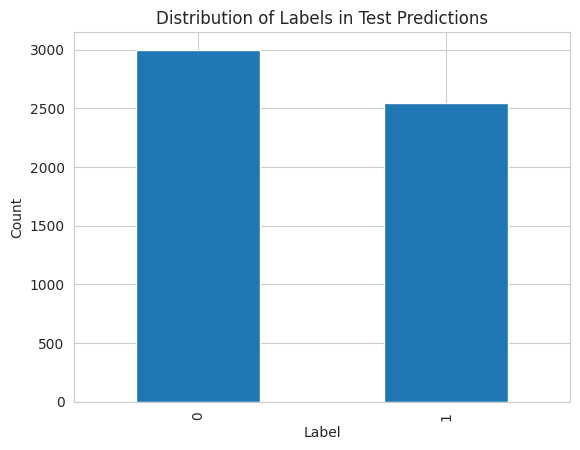

In [ ]:
def plot_submission(submission_df):
    # Analyze the distribution of the 'label' field in test_predictions to make sure the data looks acceptable
    print(submission_df['label'].value_counts())
    submission_df['label'].value_counts().plot(kind='bar')
    plt.title('Distribution of Labels in Test Predictions')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_submission(submission_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      4013
           1       0.83      0.80      0.82      3982

    accuracy                           0.82      7995
   macro avg       0.82      0.82      0.82      7995
weighted avg       0.82      0.82      0.82      7995



<ipython-input-65-a403eb62c103>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model(torch.tensor(X_np_val, device=device, dtype=torch.float32)).argmax(dim=1).cpu().numpy()


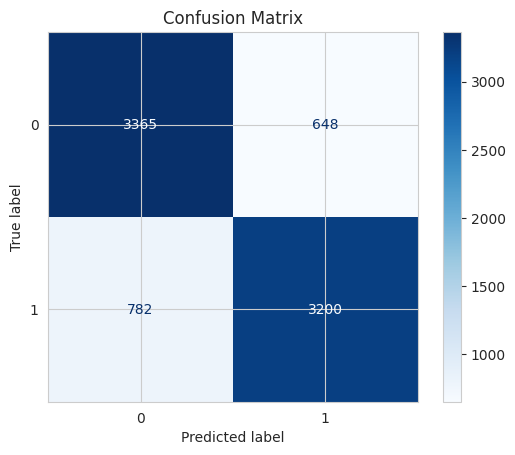

In [ ]:
# Do a little visualization

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Get best estimator from GridSearchCV
scaler = StandardScaler()
X_np_val = scaler.fit_transform(X_np_val)  # Ideally, use training scaler
X_np_val = torch.from_numpy(X_np_val).float()

# Predict on the training data (or validation/test set if available)
with torch.no_grad():
    model.eval()
    y_pred = model(torch.tensor(X_np_val, device=device, dtype=torch.float32)).argmax(dim=1).cpu().numpy()


# Classification report
print("Classification Report:")
print(classification_report(y_np_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_np_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_np_val))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

<ipython-input-66-cb7b8a809883>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_logits = model(torch.tensor(X_np_val, device=device, dtype=torch.float32)).cpu().numpy()


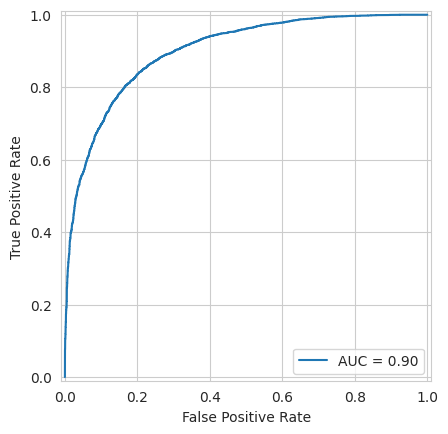

In [ ]:
with torch.no_grad():
    model.eval()
    y_val_logits = model(torch.tensor(X_np_val, device=device, dtype=torch.float32)).cpu().numpy()

    # Apply sigmoid or softmax to get probabilities for class 1
    y_val_prob = torch.sigmoid(torch.tensor(y_val_logits[:, 1])).numpy()

fpr, tpr, _ = roc_curve(y_np_val, y_val_prob)  # for binary
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [ ]:
X_train, X_val, y_train, y_val = None, None, None, None

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=1234),
    "Perceptron": Perceptron(random_state=1234),
    "NaiveBayes": GaussianNB(),
    "LogisticRegression": LogisticRegression(random_state=1234, max_iter=150, n_jobs=-1),
    "GradientBoosting": HistGradientBoostingClassifier(random_state=1234),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=1234, max_depth=7, n_jobs=-1),
    "XGBoost": XGBClassifier(n_jobs=-1, random_state=1234),
    "SGD": SGDClassifier(loss="log_loss", max_iter=1000, random_state=1234),
    "lightgbm": LGBMClassifier(n_jobs=-1, random_state=1234)
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# Evaluate each classifier
for name, model in models.items():
    print(f"\nEvaluating model: {name}")
    fold_f1s = []
    fold_imps = []


    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np_train, y_np_train), 1):
        X_train, X_val = X_np_train[train_idx], X_np_train[val_idx]
        y_train, y_val = y_np_train[train_idx], y_np_train[val_idx]

        # Scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Fit and evaluate
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        print(f"  Fold {fold} F1: {f1:.4f}")
        fold_f1s.append(f1)
        train_sizes, train_scores, val_scores = learning_curve(
            estimator=model, X=X_val, y=y_val, shuffle=True, scoring='f1_macro', random_state=1234
        )
        results[name] = results.get(name, {})
        results[name][f"fold_{fold}_learning_curve"] = (train_sizes, train_scores, val_scores)
        # fold_imps.append(permutation_importance(model, X_val, y_val, scoring='f1_macro', random_state=1234))

    mean_f1 = np.mean(fold_f1s)
    mean_imps = np.mean([imp['importances_mean'] for imp in fold_imps], axis=0)
    print(f"=> {name} Mean F1: {mean_f1:.4f}")
    results[name]['mean_f1'] = mean_f1
    results[name]['mean_imps'] = mean_imps

# Print best model
best_model = max(results.items(), key=lambda x: x[1]['mean_f1'])
print(f"\nBest Model: {best_model[0]} with F1: {best_model[1]['mean_f1']}")



Evaluating model: DecisionTree
  Fold 1 F1: 0.6854
  Fold 2 F1: 0.6857
  Fold 3 F1: 0.6892
  Fold 4 F1: 0.6961
  Fold 5 F1: 0.6899


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> DecisionTree Mean F1: 0.6892

Evaluating model: Perceptron
  Fold 1 F1: 0.6748
  Fold 2 F1: 0.6721
  Fold 3 F1: 0.7109
  Fold 4 F1: 0.6932
  Fold 5 F1: 0.6651


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> Perceptron Mean F1: 0.6832

Evaluating model: NaiveBayes
  Fold 1 F1: 0.6204
  Fold 2 F1: 0.6208
  Fold 3 F1: 0.6195
  Fold 4 F1: 0.6324
  Fold 5 F1: 0.6226
=> NaiveBayes Mean F1: 0.6231

Evaluating model: LogisticRegression


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Fold 1 F1: 0.7879
  Fold 2 F1: 0.7864
  Fold 3 F1: 0.7858
  Fold 4 F1: 0.7964
  Fold 5 F1: 0.7971


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> LogisticRegression Mean F1: 0.7907

Evaluating model: GradientBoosting
  Fold 1 F1: 0.7923
  Fold 2 F1: 0.7879
  Fold 3 F1: 0.7943
  Fold 4 F1: 0.8040
  Fold 5 F1: 0.7983


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> GradientBoosting Mean F1: 0.7954

Evaluating model: RandomForest
  Fold 1 F1: 0.7114
  Fold 2 F1: 0.7081
  Fold 3 F1: 0.7144
  Fold 4 F1: 0.7298
  Fold 5 F1: 0.7159


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> RandomForest Mean F1: 0.7159

Evaluating model: XGBoost
  Fold 1 F1: 0.7939
  Fold 2 F1: 0.7884
  Fold 3 F1: 0.7974
  Fold 4 F1: 0.8039
  Fold 5 F1: 0.8034


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> XGBoost Mean F1: 0.7974

Evaluating model: SGD
  Fold 1 F1: 0.7892
  Fold 2 F1: 0.7786
  Fold 3 F1: 0.7853
  Fold 4 F1: 0.7949
  Fold 5 F1: 0.7927


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=> SGD Mean F1: 0.7882

Evaluating model: lightgbm
[LightGBM] [Info] Number of positive: 28794, number of negative: 28770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29872
[LightGBM] [Info] Number of data points in the train set: 57564, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500208 -> initscore=0.000834
[LightGBM] [Info] Start training from score 0.000834
  Fold 1 F1: 0.7918
[LightGBM] [Info] Number of positive: 595, number of negative: 556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29846
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516942 -> initscore=0.067793

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Plotting learning curves for DecisionTree
Found 5 learning curve keys:


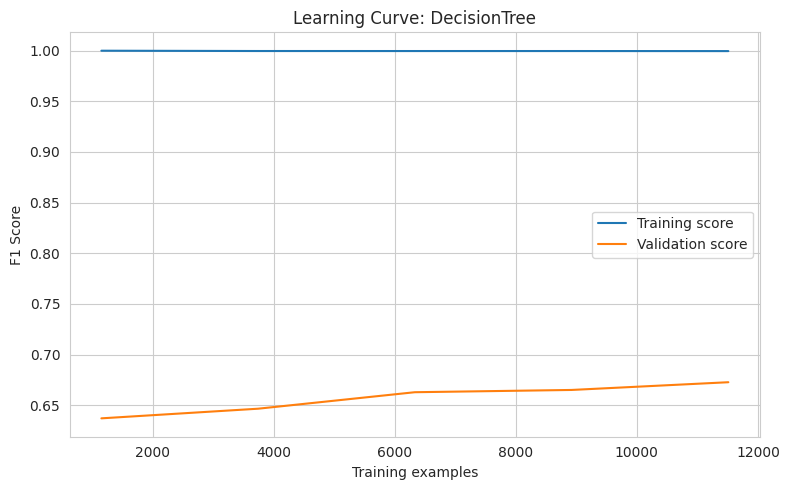

Plotting learning curves for Perceptron
Found 5 learning curve keys:


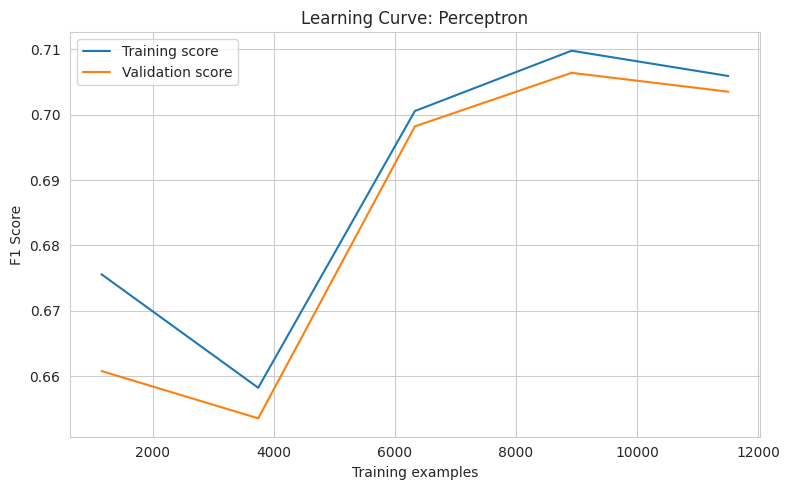

Plotting learning curves for NaiveBayes
Found 5 learning curve keys:


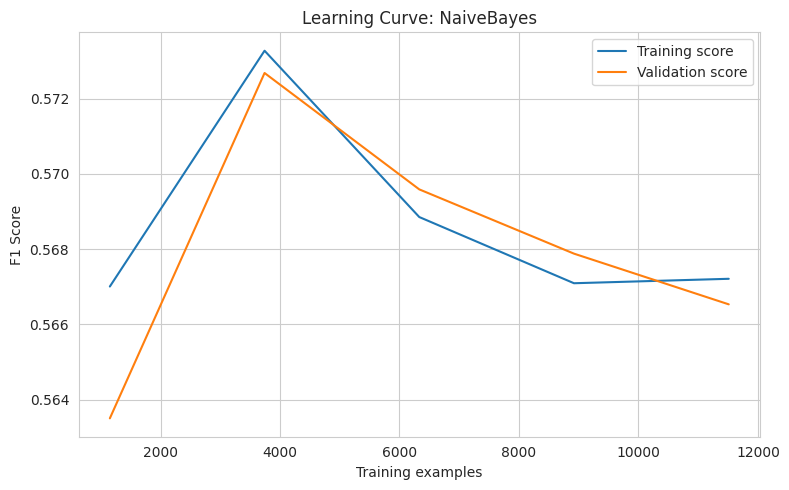

Plotting learning curves for LogisticRegression
Found 5 learning curve keys:


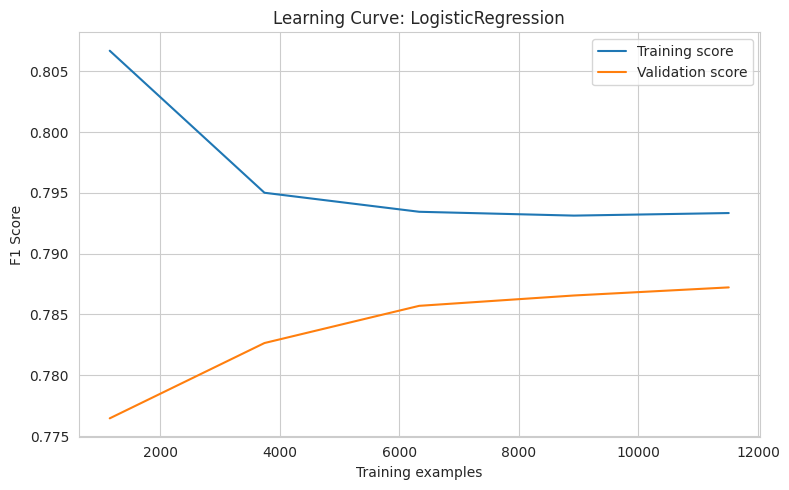

Plotting learning curves for GradientBoosting
Found 5 learning curve keys:


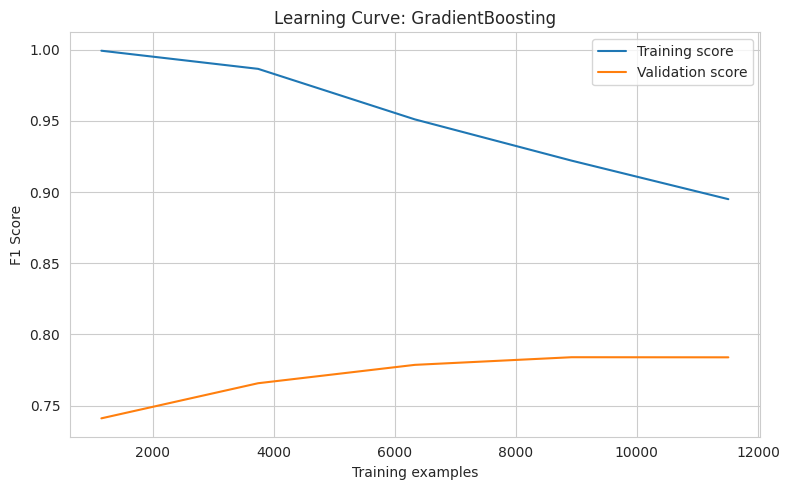

Plotting learning curves for RandomForest
Found 5 learning curve keys:


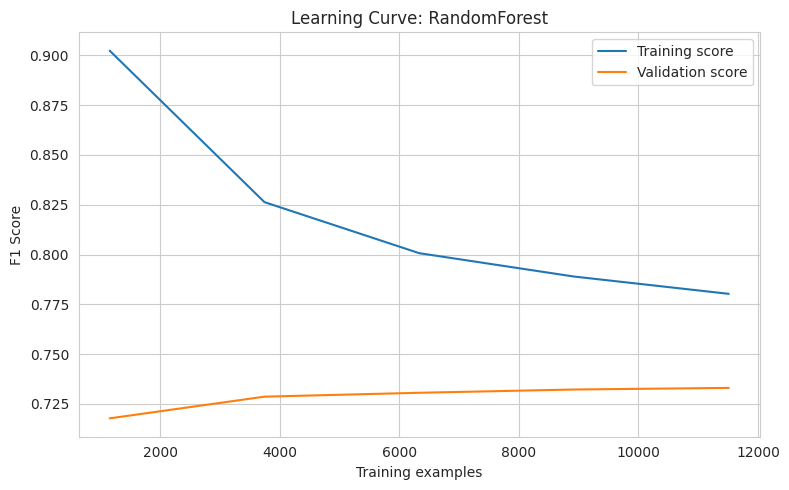

Plotting learning curves for XGBoost
Found 5 learning curve keys:


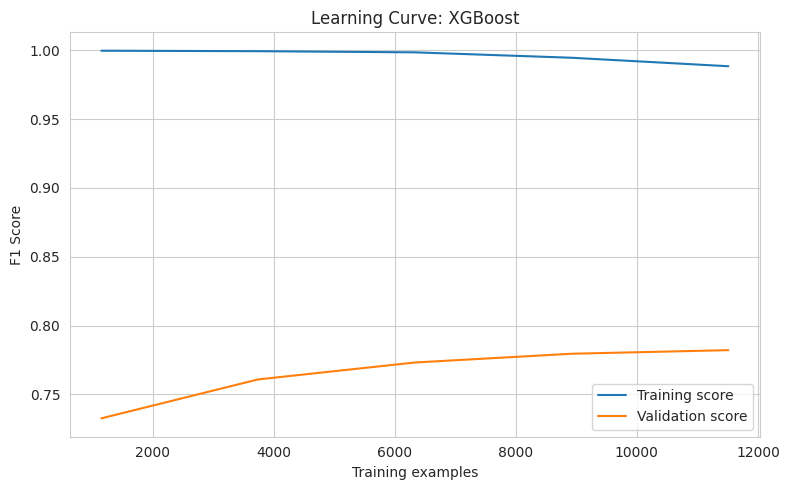

Plotting learning curves for SGD
Found 5 learning curve keys:


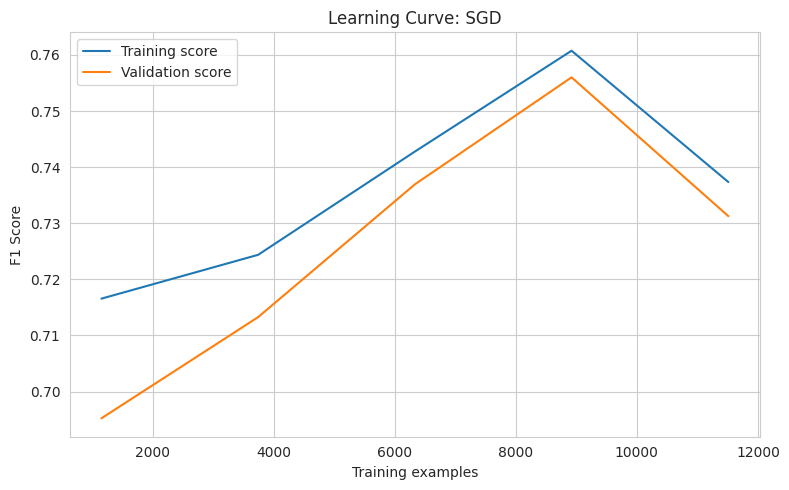

Plotting learning curves for lightgbm
Found 5 learning curve keys:


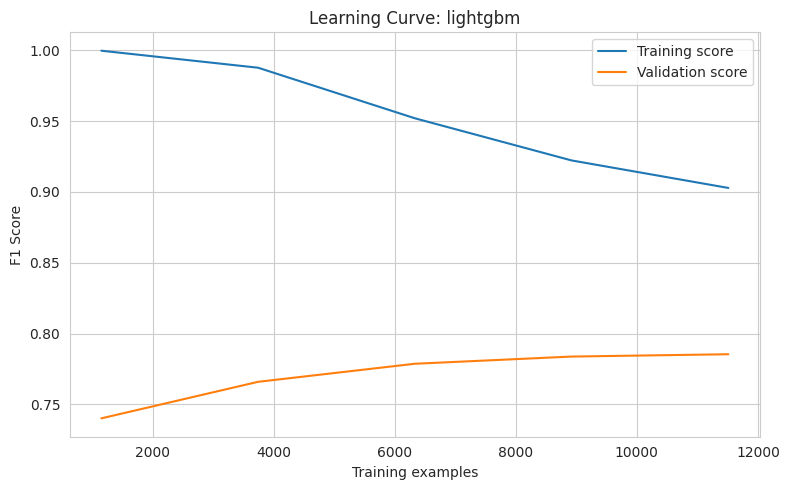

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(results_dict):
    for model_name, metrics in results_dict.items():
        print(f"Plotting learning curves for {model_name}")
        # Filter keys that contain learning curve data
        curve_keys = [k for k in metrics if k.startswith("fold_") and "learning_curve" in k]
        print(f"Found {len(curve_keys)} learning curve keys:")
        if not curve_keys:
            continue

        # Aggregate over folds
        all_train_sizes = []
        all_train_scores = []
        all_val_scores = []

        for key in curve_keys:
            train_sizes, train_scores, val_scores = metrics[key]
            all_train_sizes.append(train_sizes)
            all_train_scores.append(train_scores)
            all_val_scores.append(val_scores)

        all_train_scores = np.mean(all_train_scores, axis=0)
        all_val_scores = np.mean(all_val_scores, axis=0)
        train_sizes = all_train_sizes[0]

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, np.mean(all_train_scores, axis=1), label="Training score")
        plt.plot(train_sizes, np.mean(all_val_scores, axis=1), label="Validation score")
        plt.title(f"Learning Curve: {model_name}")
        plt.xlabel("Training examples")
        plt.ylabel("F1 Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_learning_curves(results)


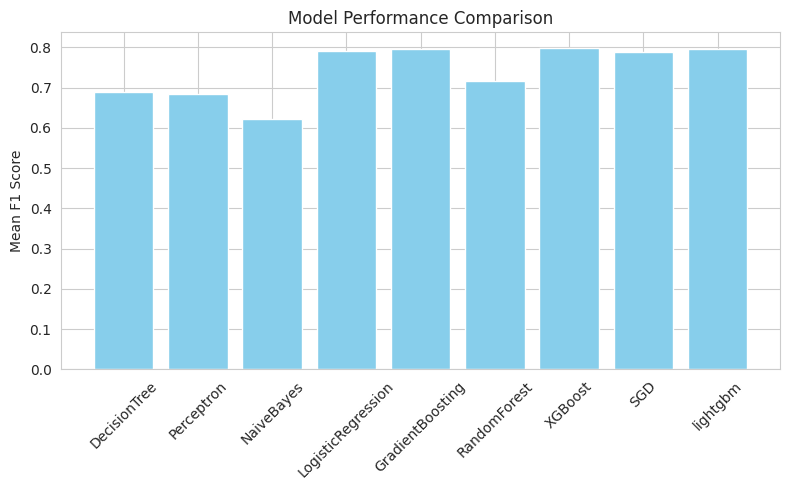

In [ ]:


def plot_model_performance(results_dict):
    model_names = []
    f1_scores = []

    for model_name, metrics in results_dict.items():
        if "mean_f1" in metrics:
            model_names.append(model_name)
            f1_scores.append(metrics["mean_f1"])

    plt.figure(figsize=(8, 5))
    plt.bar(model_names, f1_scores, color="skyblue")
    plt.ylabel("Mean F1 Score")
    plt.title("Model Performance Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

plot_model_performance(results)

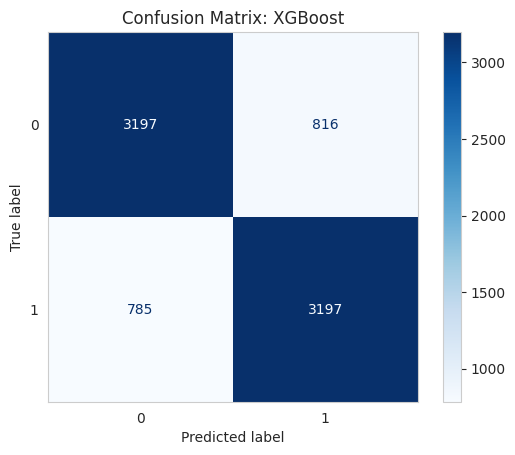

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.grid(False)
    plt.show()


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_np_train)
X_test_scaled = scaler.fit_transform(X_np_val)

best_model_name = best_model[0]
best_model_instance = models[best_model_name]
best_model_instance.fit(scaler.fit_transform(X_train_scaled), y_np_train)

plot_confusion_matrix(best_model_instance, X_test_scaled, y_np_val, best_model_name)


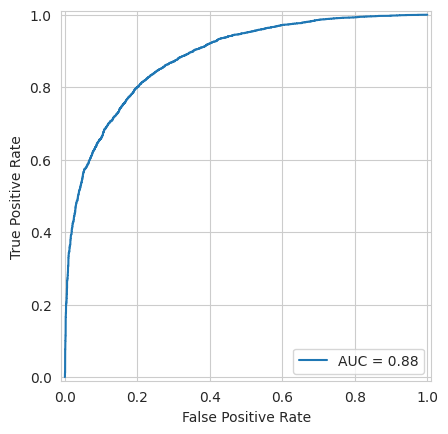

In [ ]:
y_val_prob = best_model_instance.predict_proba(X_np_val)[:, 1]
fpr, tpr, _ = roc_curve(y_np_val, y_val_prob)  # for binary
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [ ]:
y_pred = best_model_instance.predict(X_np_test)

test_predictions = np.array(y_pred)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions  # Assign 1D predictions

submission_df.to_csv("submission.csv", index=False)

label
1    2786
0    2754
Name: count, dtype: int64


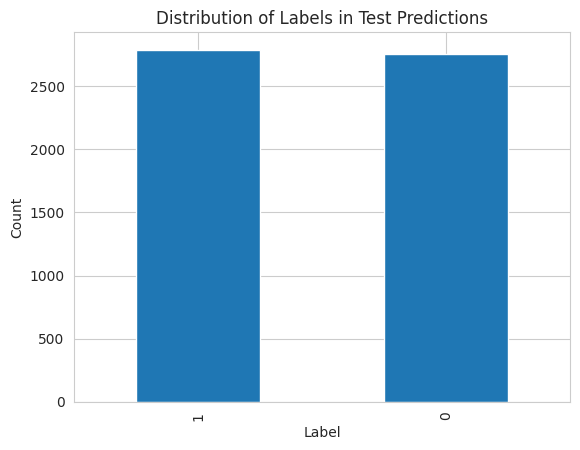

In [ ]:
plot_submission(submission_df)